# Assignment for Wolt Data Science Summer 2021 Internship

## 1 Analysing the flow of orders

The dataset consists of time series data of orders placed via Wolt between 2020-08-01 and 2020-09-30. We will chose to focus on **predicting the number of orders per day** 
and any other patterns/predictions that can be inferred. The data looks to be quite clean, with little missing data, inconsistencies etc.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "/home/tommi/Data/Wolt_orders/orders_autumn_2020.csv"
df = pd.read_csv(file_path, parse_dates = ['TIMESTAMP'], index_col = 'TIMESTAMP')

In [7]:
df.head()

,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION
TIMESTAMP,,,,,,,,,,,,
2020-08-01 06:07:00,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0
2020-08-01 06:17:00,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0
2020-08-01 06:54:00,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,15.0,3.53644,0.0
2020-08-01 07:09:00,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,16.7,3.52267,0.0
2020-08-01 07:10:00,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,16.7,3.52267,0.0


### 1.1 Data exploration and formatting

For predicting the flow of orders per given day we resample the data with the frequency of one day. The variable of interest is the number of orders per given day 'COUNT', which we create. It is plausible that a dependence on the day of the week exists (i.e. more orders on weekend for example), so we introduce the index 'WEEKDAY' and a boolean 'WEEKEND' to tell weekends (Fri-Sat-Sun) apart. All other data we neglect. For later analysis it is also useful to introduce the time in days since the start of observations 'TIME_CHANGE'.

In [246]:
# Creating 'COUNT','COUNT_FLOW' and dropping others. 
cols = df.columns.to_list()
df = df.drop(cols, axis=1)
df['COUNT'] = 1
df = df.resample('1D').sum()

# Creating 'WEEKDAY' and 'WEEKEND'
df['DAY_OF_WEEK'] = df.index.weekday
df['WEEKEND'] = df['DAY_OF_WEEK'].isin([4,5,6])
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].replace([*range(0,7)],['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Creating 'TIME_CHANGE'
df['TIME_CHANGE'] = df.index - df.index[0]
df['TIME_CHANGE'] = df['TIME_CHANGE'].apply(lambda x: x.total_seconds())/(60**2*24)

In [247]:
df.tail(10)

,COUNT,DAY_OF_WEEK,WEEKEND,TIME_CHANGE
TIMESTAMP,,,,
2020-09-21,294,Mon,False,51.0
2020-09-22,291,Tue,False,52.0
2020-09-23,287,Wed,False,53.0
2020-09-24,278,Thu,False,54.0
2020-09-25,393,Fri,True,55.0
2020-09-26,364,Sat,True,56.0
2020-09-27,386,Sun,True,57.0
2020-09-28,284,Mon,False,58.0
2020-09-29,260,Tue,False,59.0


#### Some illustrations

The colored region in the line plots illustrates the 90% confidence interval.

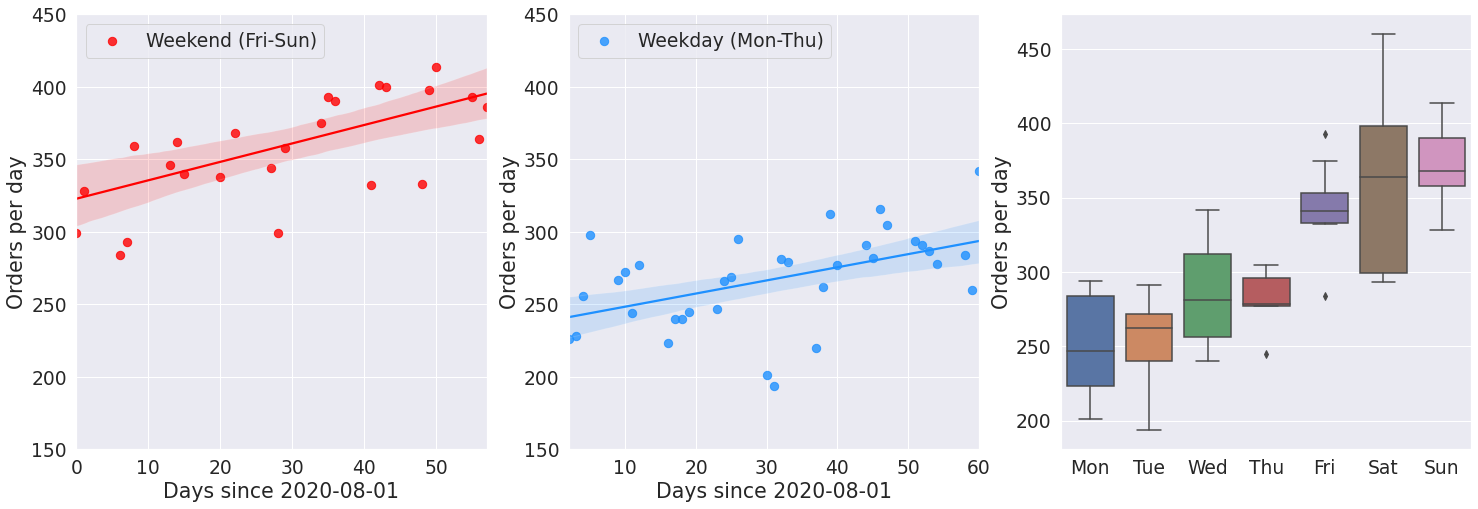

In [315]:
_= sns.set(font_scale=1.7)
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(25,8))

# Scatter plots
_ = sns.regplot(data = df[df['WEEKEND']==True], x = 'TIME_CHANGE', y = 'COUNT', color = 'red', ax = ax[0], label = 'Weekend (Fri-Sun)', scatter_kws={'s':70}, ci = 90)
_ = ax[0].set(ylim=(150, 450))
_ = ax[0].set_xlabel('Days since 2020-08-01')
_ = ax[0].set_ylabel('Orders per day')
_ = ax[0].legend(loc=2)

_ = sns.regplot(data = df[df['WEEKEND']==False], x = 'TIME_CHANGE', y = 'COUNT', color = 'dodgerblue', ax = ax[1], label = 'Weekday (Mon-Thu)', scatter_kws={'s':70}, ci = 90)
_ = ax[1].set(ylim=(150, 450))
_ = ax[1].set_xlabel('Days since 2020-08-01')
_ = ax[1].set_ylabel('Orders per day')
_ = ax[1].legend(loc=2)

# Boxplot
_ = sns.boxplot(x="DAY_OF_WEEK", y="COUNT", data=df, order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], ax = ax[2])
_ = ax[2].set_ylabel('Orders per day')
_ = ax[2].set_xlabel('')

plt.show()

#### Pearson correlation

As visible in the plots, the corrleation is moderataely strong.

In [249]:
r1 = np.corrcoef(df[df['WEEKEND']==True]['COUNT'], df[df['WEEKEND']==True]['TIME_CHANGE'])[0,1]
r2 = np.corrcoef(df[df['WEEKEND']==False]['COUNT'], df[df['WEEKEND']==False]['TIME_CHANGE'])[0,1]
r3 = np.corrcoef(df['COUNT'], df['TIME_CHANGE'])[0,1]
print("Correlation for days on weekend: {:.2}, on weekdays: {:.2} and for the whole set: {:.2}".format(r1,r2,r3))

Correlation for days on weekend: 0.55, on weekdays: 0.49 and for the whole set: 0.28


### 1.2 Analysis via linear regression and bootstrapping

Based on the exploratory analysis a simple linear model seems give a reasonable model for predicting the number of orders, expecially when taking the increase of orders on weekends into account, which we introduce as a categorical variable. This results in the standard linear **parallel slopes model**. We asses the goodness of fit by calculating the RMS error and calculate the confidence interval via pairwise bootstrapping.

In [250]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Linear Regression 
X = df[['TIME_CHANGE','WEEKEND']]
y = df['COUNT']
LR = LinearRegression()
_= LR.fit(np.array(X), np.array(y))

# Coefficients of the line y = a + k*x + b*categorical(0 or 1)
a, k, b = LR.intercept_, LR.coef_[0], LR.coef_[1]
x_min, x_max = df['TIME_CHANGE'].min(), df['TIME_CHANGE'].max()
Y_min = [a + k*x_min + b*1, a + k*x_min]
Y_max = [a + k*x_max + b*1, a + k*x_max]

# RMS error
print("RMS error in order prediction per day: {:.4}".format(mean_squared_error(LR.predict(X), y)**(1/2)))

RMS error in order prediction per day: 31.07


#### In order to gauge the reliability of the model, we generate 1000 bootstrap samples of the data (with replacement).

In [251]:
# 1000 bootstrap samples
Y_min_b = []
Y_max_b = []

for i in range(0,1000):
    ''' Bootstrapping a dataframe with replacement and generating the corresponding linear fits'''
    
    # Samples
    dg = df.sample(n=len(df), replace=True, random_state = i)
    X = dg[['TIME_CHANGE','WEEKEND']]
    y = dg['COUNT']
    
    # Linear Reg
    LR_b = LinearRegression()
    _= LR_b.fit(np.array(X), np.array(y))
    
    # Start and end points of lines
    a, k, b = LR_b.intercept_, LR_b.coef_[0], LR_b.coef_[1]
    Y_min_b.append([a + k*x_min + b*1, a + k*x_min])
    Y_max_b.append([a + k*x_max + b*1, a + k*x_max])

# Confidence intervals
def conf_inter(x):
    ''' Defining confidence limits for the bootsrapped lines,
    input is a list (e.g. x = [5, 95] for 90% CL)'''
    return [np.percentile(np.array(y)[:,i], x) for i in [0,1] for y in [Y_min_b, Y_max_b]]

#### The parallel lines model and the bootstrapped lines for assessing the error, using a 90% confidence interval

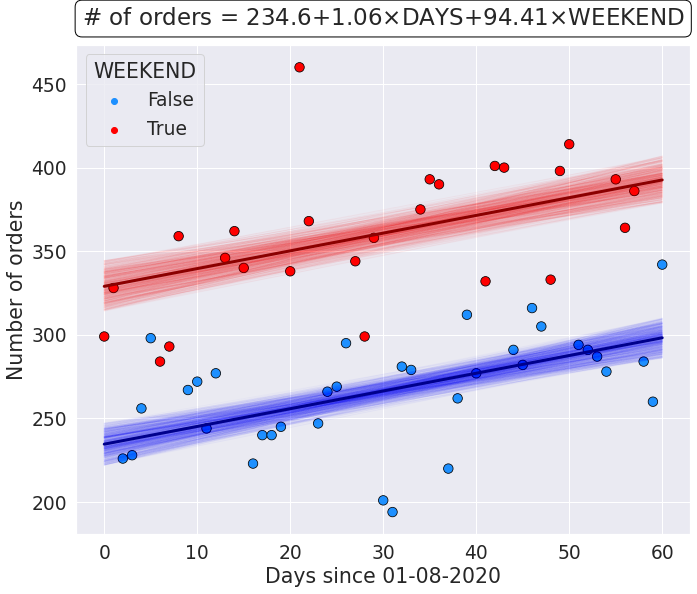

In [328]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (11,9))

# Scatterplot
_ = sns.scatterplot(data = df, x = 'TIME_CHANGE', y = 'COUNT', hue = 'WEEKEND', palette = ['dodgerblue', 'red']\
                    ,edgecolor = 'black', ax = ax, s = 90)
_ = ax.set_xlabel('Days since 01-08-2020')
_ = ax.set_ylabel('Number of orders')

# Bootsrapped lines, 90% confidence interval
CL = conf_inter([5,95])
for i in range(0,len(Y_min_b)):
    if (Y_min_b[i][0] > CL[0][0]) and (Y_min_b[i][0] < CL[0][1])\
    and (Y_max_b[i][0] > CL[1][0]) and (Y_max_b[i][0] < CL[1][1]):
        _ = ax.plot([x_min,x_max], [Y_min_b[i][0], Y_max_b[i][0]], linewidth = 1, color = 'red', alpha = 0.02)
    if (Y_min_b[i][1] > CL[2][0]) and (Y_min_b[i][1] < CL[2][1])\
    and (Y_max_b[i][1] > CL[3][0]) and (Y_max_b[i][1] < CL[3][1]):
        _ = ax.plot([x_min,x_max], [Y_min_b[i][1], Y_max_b[i][1]], linewidth = 1, color = 'blue', alpha = 0.02)
        
# The parallel slopes model
_ = ax.plot([x_min,x_max], [Y_min[0], Y_max[0]], linewidth = 3, color = 'darkred')
_ = ax.plot([x_min,x_max], [Y_min[1], Y_max[1]], linewidth = 3, color = 'darkblue')

# The model coefficients
_ = ax.set_title(r'# of orders = {:.4}$+${:.3}$\times$DAYS$+${:.4}$\times$WEEKEND'
                 .format(LR.intercept_,LR.coef_[0], LR.coef_[1]), fontsize=23, pad = 20,\
                bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))
plt.show()

#### Conclusions from the parallel slopes model
The parallel slopes model gives quite robust predictions based on the bootsrapped lines and the RMS error.  Since it is a linear model it would be quite easy to implement in practice, for example in **forecasting the additional number of drivers needed in the future**. Some key findings based on the model above are:
- On average there are 94 more orders on days on weekends compared to weekdays and the difference is statistically significant.
- The trend in number of orders is growing, on average roughly 1 per day (i.e. 7 per week).
- The variance is moderately high, about 31 orders per day.

### 1.3 Analysis via a regression tree
Now we assess the data with a regression tree model, wich give a handle on any possible non-linearities not visble in the previous model. With more time and resources a proper optimization of the hyperparameters should be performed. However, having a reliable and predictive model would likely require data gathered over a longer time interval. As it stands there is a risk of overfitting, which we control by limiting the minimum samples in a leaf. 

In [312]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = X['WEEKEND'])

# Create the regressor
dt = DecisionTreeRegressor(min_samples_leaf = 0.2, random_state = 2)
_ = dt.fit(X_train, y_train)

# RMS error for test set
y_pred = dt.predict(X_test)
print("RMS error in order prediction per day: {:.4}".format(mean_squared_error(y_pred, y_test)**(1/2)))

# Save predictions for the whole data set
df['TREE_MODEL'] = dt.predict(df[['TIME_CHANGE', 'WEEKEND']])

RMS error in order prediction per day: 32.3


The error is larger than in the linear model and furthermore can be shown to be quite sensitive to the used hyperparameters and even the random state chosen. **This indicates that it lacks predictive power**.

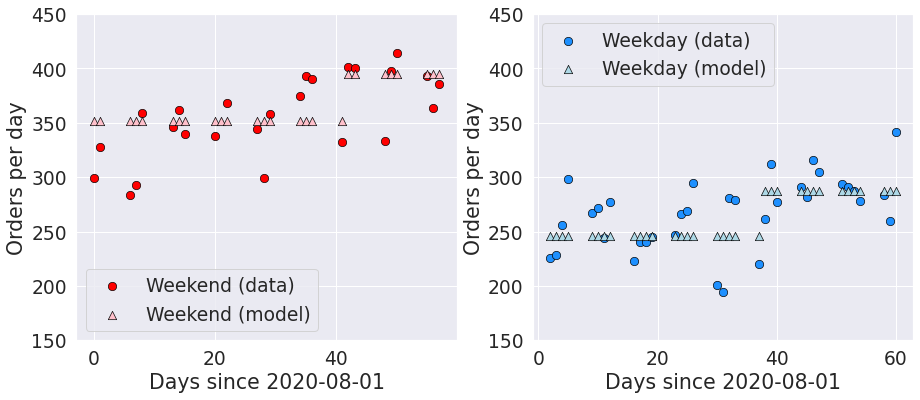

In [313]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,6))

# Scatterplots
_ = sns.scatterplot(data = df[df['WEEKEND']==True], x = 'TIME_CHANGE', y = 'COUNT', color = 'red', ax = ax[0], s = 70, label = 'Weekend (data)', edgecolor = 'black')
_ = sns.scatterplot(data = df[df['WEEKEND']==True], x = 'TIME_CHANGE', y = 'TREE_MODEL', color = 'pink', ax = ax[0], s = 70, label = 'Weekend (model)', edgecolor = 'black', marker="^")
_ = ax[0].set(ylim=(150, 450))
_ = ax[0].set_xlabel('Days since 2020-08-01')
_ = ax[0].set_ylabel('Orders per day')
_ = ax[0].legend(loc=3)

_ = sns.scatterplot(data = df[df['WEEKEND']==False], x = 'TIME_CHANGE', y = 'COUNT', color = 'dodgerblue', ax = ax[1], s = 70, label = 'Weekday (data)', edgecolor = 'black')
_ = sns.scatterplot(data = df[df['WEEKEND']==False], x = 'TIME_CHANGE', y = 'TREE_MODEL', color = 'lightblue', ax = ax[1], s = 70, label = 'Weekday (model)', edgecolor = 'black', marker="^")
_ = ax[1].set(ylim=(150, 450))
_ = ax[1].set_xlabel('Days since 2020-08-01')
_ = ax[1].set_ylabel('Orders per day')
_ = ax[1].legend(loc=2)

plt.show()

#### Prediction for the difference of average number of orders on weekends vs weekdays 

In [314]:
df.groupby('WEEKEND').mean()['TREE_MODEL'].diff().iloc[1]

102.57553270259166

#### Conclusions from the regression tree model
After some experimentation with the hyperparameters, it seems that there is not enough data to make the model robust. Having, say, 10 months of observations could give a better indication whether the tree model is also useful for this problem. Based on this model we can tentatively infer that:
- There is a persistent average difference on the orders made on weekends compared to weekdays roughly of 100 orders.
- The trend in number of orders is a growing one.

## 2 My background and Wolt

In my academic work I have studied extensively stochastic dynamical porcesses, which in my mind could be quite a useful template in analysing time series. Such techniques are already frequently implemented in finance (commonly known as te Black-Scholes equation), but given my background in quantum field theory I suspect I might have a fresh take on their application. This would perhas allows a more detailed analysis on how the number of orders fluctuates during smalles time scales, possibly allowing a better understanding how the orders are distributed on a given day. 